## Part 3: Model Building and Validation

This is the final section of this project. This is the part where we find a solution to our primary objective:
 - Develop a Demand Forecast to assist the business with Supply Planning.

Let's start by importing our modules and data.

In [1]:
import pandas as pd
import numpy as np

import datetime as dt
import itertools

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
% matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt


In [2]:
Store_312 = pd.read_csv("/Users/mac/Desktop/Data Science/Projects/TinyCo Project/Store_312_clean.csv", index_col=0)

In [3]:
Store_312.head()

,SKU,Date,Unit Sales,Dollar Sales
0,50012011250,2014-08-04,3,29.97
1,50012011250,2014-08-05,2,19.98
2,50012011250,2014-08-06,5,49.95
3,50012011250,2014-08-07,3,29.97
4,50012011250,2014-08-08,7,69.93


Let's set the date as our index as we did previously.

In [4]:
Store_312["Date"] = pd.to_datetime(Store_312["Date"])
Store_312.set_index("Date", inplace=True)
Store_312.head()

,SKU,Unit Sales,Dollar Sales
Date,,,
2014-08-04,50012011250,3,29.97
2014-08-05,50012011250,2,19.98
2014-08-06,50012011250,5,49.95
2014-08-07,50012011250,3,29.97
2014-08-08,50012011250,7,69.93


In [5]:
Store_312.dtypes

SKU               int64
Unit Sales        int64
Dollar Sales    float64
dtype: object

Our data types seem to be correct and our datetimeindex is set. All good for now.

The Supply Chain Department would like to know how to plan for stocks on a weekly basis. Therefore, the model we produce should forecast unit sales on the same time period. Another thing that's crucial for the SCD is the splits of the SKUs. They'd like to know the granular contribution of each SKU to the overall forecast.

First, Let's deal with the overall forecast.

### ***a. Overall Forecast***

#### Visualizing the Data

Let's plot a time series, in weekly buckets, of the unit sales for Store 312.

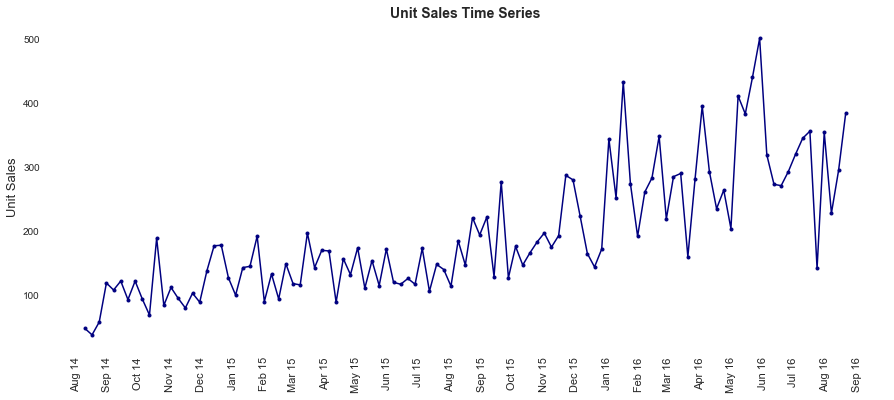

In [6]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(Store_312["Unit Sales"].resample("W").sum(), marker='.', color="navy")
ax.set_ylabel("Unit Sales", fontsize=13)
ax.set_title("Unit Sales Time Series", fontsize=14, fontweight="bold")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

plt.xticks(rotation=90, fontsize=11)

sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
plt.show()

In [7]:
print("There are {} weeks in our dataset.".format(len(Store_312.resample("W").sum())))

There are 107 weeks in our dataset.


In [8]:
Store_312.resample("W").sum().head(2)

,SKU,Unit Sales,Dollar Sales
Date,,,
2014-08-10,750180168960,48,413.52
2014-08-17,700168157920,38,301.62


In [9]:
Store_312.resample("W").sum().tail(23)

,SKU,Unit Sales,Dollar Sales
Date,,,
2016-03-20,951945531318,160,2315.40
2016-03-27,861986015332,281,3765.19
2016-04-03,827974906316,395,5171.05
2016-04-10,999260380135,293,3831.07
2016-04-17,911998095774,235,3200.65
2016-04-24,826111802304,264,3439.36
2016-05-01,917934560039,204,2669.96
2016-05-08,1066801349246,411,5574.89
2016-05-15,1268024571828,383,5135.17


Let's select the first 85 weeks as our taining dataset and the last 22 as our test dataset.

In [10]:
Train = Store_312.resample("W").sum().loc["2014-08-10":"2016-03-20"]
Test = Store_312.resample("W").sum().loc["2016-03-27":"2016-08-21"]

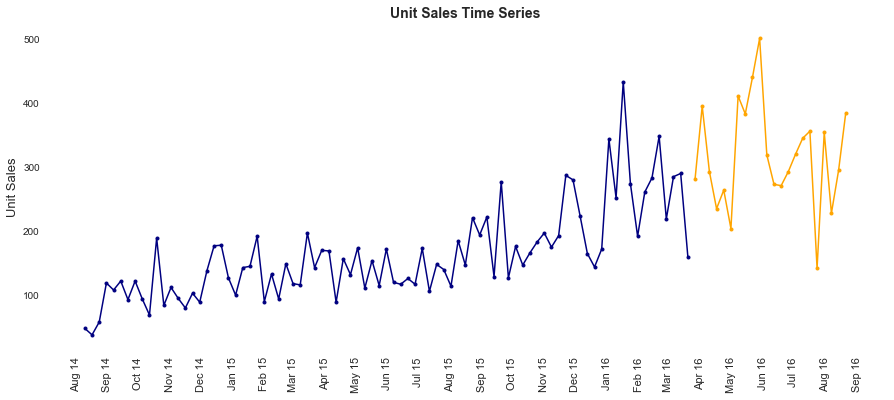

In [11]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(Train["Unit Sales"].resample("W").sum(), marker='.', color="navy")
ax.plot(Test["Unit Sales"].resample("W").sum(), marker='.', color="orange")
ax.set_ylabel("Unit Sales", fontsize=13)
ax.set_title("Unit Sales Time Series", fontsize=14, fontweight="bold")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

plt.xticks(rotation=90, fontsize=11)

sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
plt.show()

We'll use 2 models and compare them to see which model produces the least RMSE. The RMSE is the metric we're going to be using to evaluate model performance. It has been chosen because it is simple to interpret, and it also explains how well a model fits the existing data.

The 2 models which are going to be used are:
 - Holt Winter's
 - SARIMA

#### Holt Winter's

Let's model our problem using the Holt Winter's method to start with.

The reason why we're using HW is because we believe there to be a trend and seasonality in our data. Lets decompose our TS and look at these much closer.

In [12]:
week = Store_312[["Unit Sales"]].resample("W").sum()

decomposition = seasonal_decompose(week)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

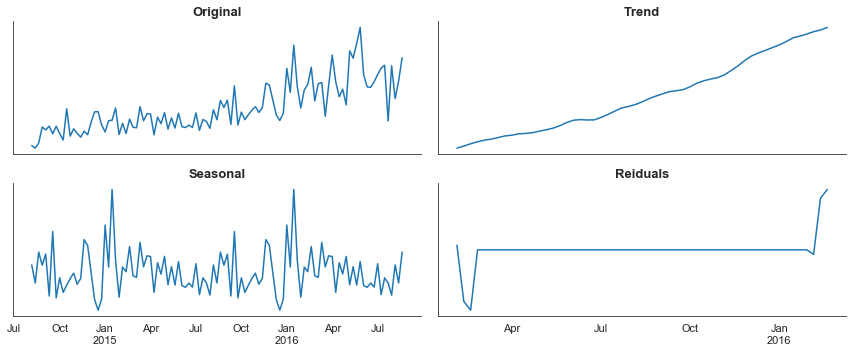

In [13]:
sns.set_style("white")

fig, axes = plt.subplots(nrows=2, ncols=2)

w = week["Unit Sales"].plot(ax=axes[0,0], figsize=(12,5))
w.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, labelleft=False)
w.set_title('Original', fontsize=13, fontweight="bold")
w.set_xlabel("")
w.legend().set_visible(False)

t = trend.plot(ax=axes[0,1])
t.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, labelleft=False)
t.set_title('Trend', fontsize=13, fontweight="bold")
t.set_xlabel("")
t.legend().set_visible(False)

s = seasonal.plot(ax=axes[1,0])
s.tick_params(axis='both', which='both', labelsize=11, labelleft=False)
s.set_title('Seasonal', fontsize=13, fontweight="bold")
s.set_xlabel("")
s.legend().set_visible(False)

r = residual.plot(ax=axes[1,1])
r.tick_params(axis='both', which='both', labelsize=11, labelleft=False)
r.set_title('Reiduals', fontsize=13, fontweight="bold")
r.set_xlabel("")
r.legend().set_visible(False)

plt.tight_layout()

plots = [w, t, s, r]

for i in plots:
    sns.despine(top=True, right=True, left=False, bottom=False, ax=i)

plt.show()

Confirming our earlier deductions from _Part 2_ of the project, there is indeed a trend and seasonality in our data. Let's proceed to apply our model.

In [14]:
print(Train.shape)
print(Test.shape)

(85, 3)
(22, 3)


In [15]:
train1_hat = ExponentialSmoothing(Train["Unit Sales"], trend='add', damped=True, seasonal='mul', seasonal_periods=19).fit(use_boxcox=True)
test1_hat = train1_hat.forecast(22)

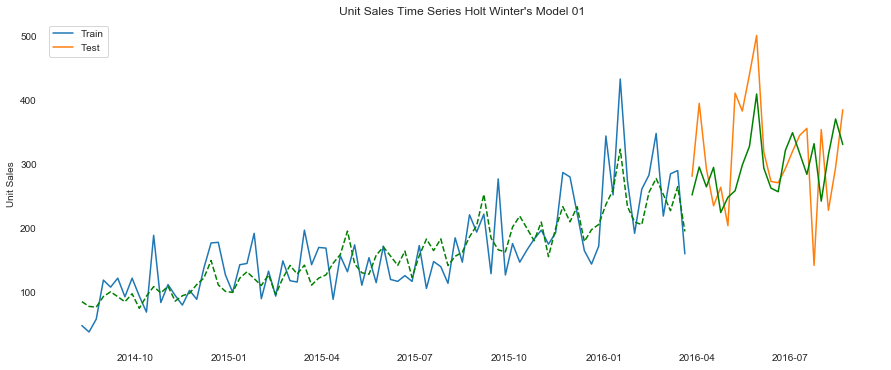

In [16]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(Train["Unit Sales"], label="Train")
ax.set_ylabel("Unit Sales")
ax.set_title("Unit Sales Time Series Holt Winter's Model 01")
ax.plot(Test["Unit Sales"], label="Test")
ax.legend(loc="upper left")
ax.plot(test1_hat, color='green')

ax.plot(train1_hat.fittedvalues, color='green', linestyle="--", label="Fitted values (Train)")

sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
plt.show()

In [17]:
rms1 = sqrt(mean_squared_error(Test["Unit Sales"], test1_hat))
rms1

80.71080298691183

#### SARIMAX

The reason why we've chosen the SARIMAX is because we've already demonstrated that our data contains a seasonal component. We'd like to forecast for this seasonality.

Ordinarily, we'd have to test for stationarity using the adf test, force stationarity on our data, then transform the data back to the original scale. Fortunately for us, the statsmodel SARIMAX model does all this for us, so we only need to apply parameters to it.

In [18]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 19) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 19)
SARIMAX: (0, 0, 1) x (0, 1, 0, 19)
SARIMAX: (0, 1, 0) x (0, 1, 1, 19)
SARIMAX: (0, 1, 0) x (1, 0, 0, 19)


This step is parameter selection for our unit sales Seasonal ARIMA time series model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model. We shall be using the Akaike Information Criteria (AIC) as a metric to evaluate model performance. The lower the AIC, the better the model.

In [19]:
import warnings
warnings.filterwarnings("ignore")

param_tabl = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(Train["Unit Sales"],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=False)
            results = mod.fit()
            params = {"p,d,q": param, "P,D,Q,s": param_seasonal, "AIC": results.aic}
            param_tabl.append(params)
            #print('SARIMA: {} x {} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [20]:
param_tabl = pd.DataFrame(param_tabl)

In [21]:
print(len(param_tabl))
param_tabl[param_tabl["AIC"]==param_tabl["AIC"].min()]

50


,AIC,"P,D,Q,s","p,d,q"
25,729.015321,"(1, 1, 0, 19)","(0, 1, 1)"


The least AIC number from our output is 729.01. The model with this AIC is SARIMA: (0, 1, 1) x (1, 1, 0, 19). These are the parameters we're going to be using for our model.

In [22]:
train2_hat = sm.tsa.statespace.SARIMAX(Train["Unit Sales"], order=(0,1,1), enforce_stationarity=True, seasonal_order=(1,1,0,19)).fit()
test2_hat = train2_hat.predict(start="2016-03-27", end="2016-08-21", dynamic=True)

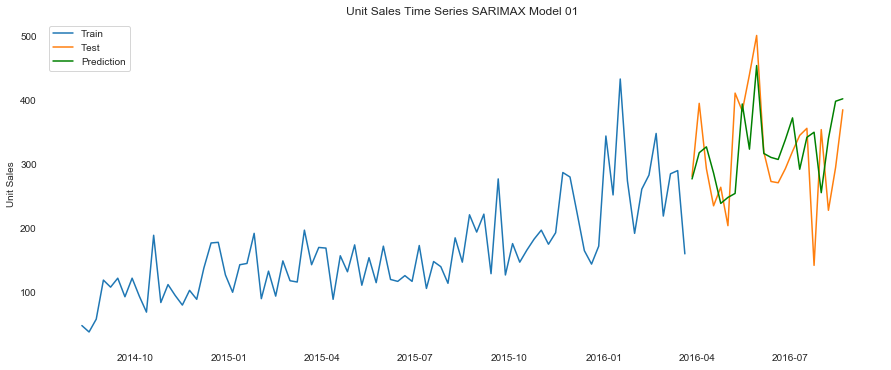

In [23]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(Train["Unit Sales"], label="Train")
ax.set_ylabel("Unit Sales")
ax.set_title("Unit Sales Time Series SARIMAX Model 01")
ax.plot(Test["Unit Sales"], label="Test")
ax.plot(test2_hat, color='green', label="Prediction")
#ax.plot(fit2.fittedvalues, color='green', linestyle="--", label="Fitted values (Train)")
ax.legend(loc="upper left")


sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
plt.show()

In [24]:
rms2 = sqrt(mean_squared_error(Test["Unit Sales"], test2_hat))
rms2

79.6898768549478

#### Model Diagnostics

In [25]:
print(train2_hat.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8647      0.072    -11.948      0.000      -1.007      -0.723
ar.S.L19      -0.3297      0.130     -2.539      0.011      -0.584      -0.075
sigma2      3754.0322    609.789      6.156      0.000    2558.868    4949.197


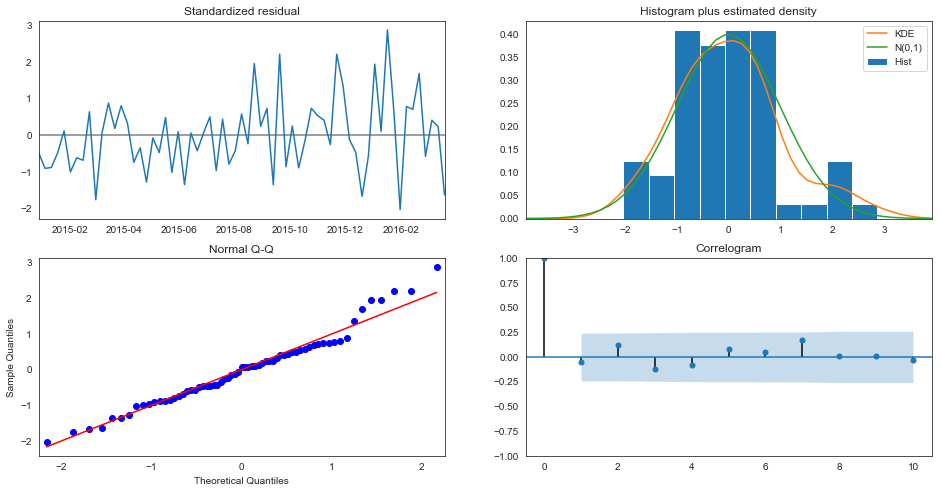

In [26]:
train2_hat.plot_diagnostics(figsize=(16, 8))
plt.show()

Although not perfect, our model diagnostics suggest that our residuals are almost normally distributed.

#### Final Model

Comparing our 2 models, the SARIMAX model is the one with a lower RMSE score. Therefore, it is the model we're going to use to build our final model.

In [27]:
Store_312_weekly = Store_312[["Unit Sales", "Dollar Sales"]].resample("W").sum()

In [28]:
Store_312_weekly.tail()

,Unit Sales,Dollar Sales
Date,,
2016-07-24,142,1837.58
2016-07-31,354,4689.46
2016-08-07,228,3032.72
2016-08-14,295,3890.05
2016-08-21,385,5335.15


In [29]:
final_fit = sm.tsa.statespace.SARIMAX(Store_312_weekly["Unit Sales"], order=(0,1,1), enforce_stationarity=True, seasonal_order=(1,1,0,19)).fit()

In [30]:
prediction = final_fit.predict(start="2016-08-28", end="2017-08-20", dynamic=True)

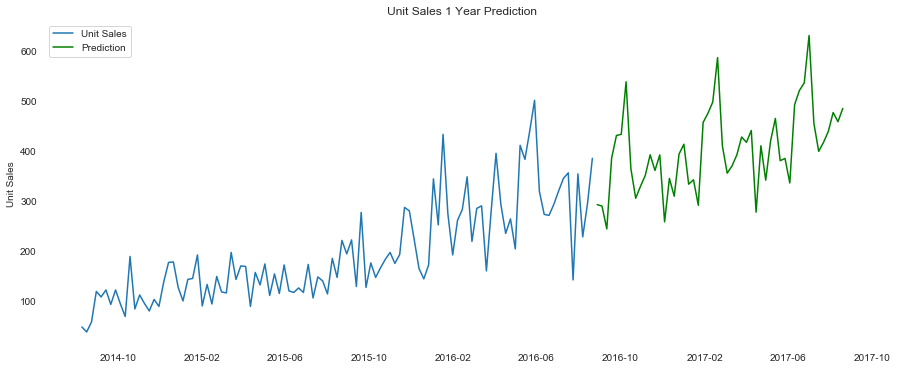

In [31]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(Store_312_weekly["Unit Sales"], label="Unit Sales")
ax.set_ylabel("Unit Sales")
ax.set_title("Unit Sales 1 Year Prediction")
ax.plot(prediction, color='green', label="Prediction")
#ax.plot(final_fit.fittedvalues, color='green', linestyle="--", label="Fitted values")
ax.legend(loc="upper left")


sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
plt.show()

The green part of our graph represents the forecast to the year ending 2017.

However, because we had very little data to begin with, our granular forecast becomes less and less accurate as time goes on. It would be better to immediately consider a forecast for say 3 months in the future, before the seasonality starts to repeat itself. After the 3 months, new data will be fed into the model to predict the next quarter and so on and so on.

However, the one year forecast can still be aggregated to produce an annual demand forecast.

In [32]:
demand_forecast_2017 = prediction.sum()

In [33]:
print("The demand, in total unit sales, for 2017 is going to be {}.".format(round(demand_forecast_2017)))

The demand, in total unit sales, for 2017 is going to be 20945.0.


#### **Demand Forecast Report**

Let's now create a report in the form of a table that summarises the forecast and what it means on a weekly perspective.

***The data we were given ends in August 2016. We will assume going forwards that the financial year for TinyCo begins in September, ending in August of the following year.***

In [34]:
## Let's confirm the numbers of weeks our forecast has.
print("The model forecasted {} weeks.".format(len(prediction)))

The model forecasted 52 weeks.


We then take the previous 52 weeks just before our forecast. This is virtually an operational financial year for our business in 2016.

In [35]:
unit_sales_16 = Store_312_weekly["Unit Sales"].loc["2015-08-30":"2016-08-21"]
len(unit_sales_16)

52

Let's create a dataframe that has the 2016 weekly sales as a column, along with the 2017 forecasted sales.

In [36]:
report = pd.DataFrame({"2016 Sales": unit_sales_16.tolist(), "2017 Sales": prediction.tolist()})

In [37]:
report.head()

,2016 Sales,2017 Sales
0,194,292.514803
1,222,289.657813
2,129,243.938533
3,277,385.393692
4,127,430.628151


In [38]:
report["2017 Sales"] = report["2017 Sales"].apply(round)

In [39]:
report.head()

,2016 Sales,2017 Sales
0,194,293
1,222,290
2,129,244
3,277,385
4,127,431


In [40]:
report["Growth %"] = (((report["2017 Sales"] - report["2016 Sales"]) / report["2016 Sales"]) *100).round()

It could be valuable to include in our report the expected weekly percentage growth for our sales.

In [41]:
report.head()

,2016 Sales,2017 Sales,Growth %
0,194,293,51.0
1,222,290,31.0
2,129,244,89.0
3,277,385,39.0
4,127,431,239.0


Let's also reset our index so that it starts at 1 and name it "Week". This will help with presentability.

In [42]:
report.index.name = "Week"
report.index += 1
report.head()

,2016 Sales,2017 Sales,Growth %
Week,,,
1,194,293,51.0
2,222,290,31.0
3,129,244,89.0
4,277,385,39.0
5,127,431,239.0


The table above summarises the 2017 projection of overall unit sales, as well as the expected percentage growth from the previous year, on a week-to-week basis.

Let's export the report so that it can be viewed by the relative stakeholders.

In [43]:
# Use your own paths.
report.to_csv("/Users/mac/Desktop/Data Science/Projects/TinyCo Project/Unit Sales Forecast Report (Overall).csv")

### ***b) SKU Split Forecast***

We've chosen the model for our overall data, and used it to forecast sales for the next financial year. Although this is helpful, we don't know how those sales are split by SKU. One way to solve this problem would be to sum up each SKU, add the SKUs together, then express each SKU's contribution as a percentage. This would work, but we'd be making the assumption that independent SKU variation does not change from week to week, or even month to month.

First of all, let's plot a time series that shows all the SKUs to investigate our claims.

In [44]:
SKU_pivot = Store_312.pivot_table(index=Store_312.index, values = 'Unit Sales', columns = 'SKU', aggfunc="sum",fill_value=0)
SKU_pivot = SKU_pivot.resample("W").sum()
SKU_pivot.head()

SKU,7312455520,7312455530,8000451112,8000520021,50012011240,50012011250,50012011340,50012011341,50013000110
Date,,,,,,,,,
2014-08-10,0,0,0,0,18,24,6,0,0
2014-08-17,0,0,0,0,9,17,12,0,0
2014-08-24,4,3,0,20,8,17,6,0,0
2014-08-31,5,8,55,15,11,18,7,0,0
2014-09-07,9,11,46,16,7,12,7,0,0


#### Visualizing the Data

Let's plot a time series, in weekly buckets, of the unit sales for each SKU in Store 312.

In [45]:
col_names = []

for name in SKU_pivot.columns:
    name = str(name)
    col_names.append(name)

In [46]:
col_names

['7312455520',
 '7312455530',
 '8000451112',
 '8000520021',
 '50012011240',
 '50012011250',
 '50012011340',
 '50012011341',
 '50013000110']

In [47]:
SKU_pivot.columns = col_names

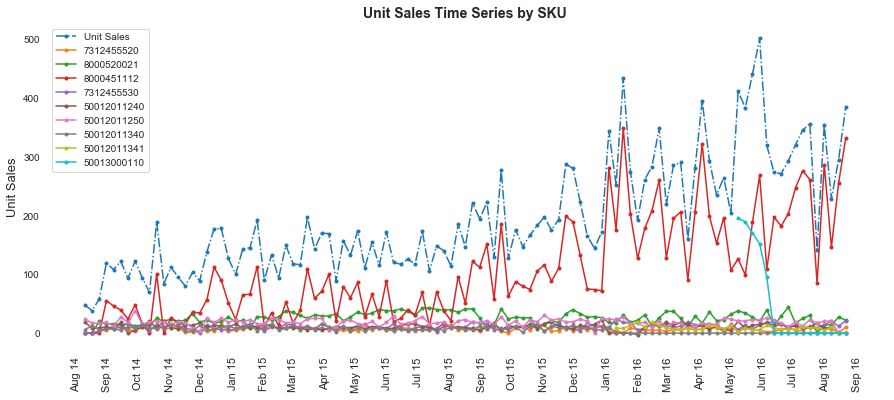

In [48]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(Store_312["Unit Sales"].resample("W").sum(), marker='.', linestyle="-.")
for sku in (set(SKU_pivot.columns)-set(["50012011341", "50013000110"])):
    ax.plot(SKU_pivot[sku], marker='.')
ax.plot(SKU_pivot["50012011341"].loc["2016-01-10":], marker='.')
ax.plot(SKU_pivot["50013000110"].loc["2016-05-08":], marker='.')
ax.set_ylabel("Unit Sales", fontsize=13)
ax.set_title("Unit Sales Time Series by SKU", fontsize=14, fontweight="bold")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax.legend(loc="upper left")

plt.xticks(rotation=90, fontsize=11)

sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
plt.show()

Interesting results from the graph, here. It seems SKU 8000451112 is the one responsible for the shape of the overall unit sales. It's the one with both the trend and the seasons.

Let's plot these individual SKUs on different axes.

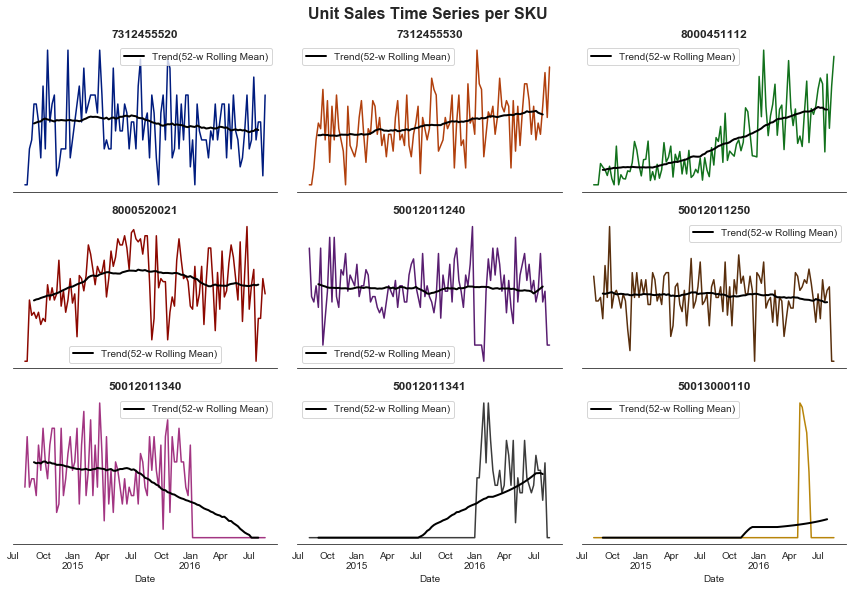

In [49]:
sns.set_style("white")
colors = sns.color_palette("dark", 9)

fig, axes = plt.subplots(nrows=3, ncols=3, sharex="row")

axes_list = [item for sublist in axes for item in sublist]

fig.suptitle("Unit Sales Time Series per SKU", fontsize=16, fontweight="bold", y=1.02)

for selection, color in zip(SKU_pivot.columns, colors):
    ax = axes_list.pop(0)
    #ax.plot(SKU_pivot.rolling(365, center=True, min_periods=365).mean(), label="Trend(365-d Rolling Mean)", linewidth=3)
    SKU_pivot.plot(y=selection, label=selection, ax=ax, legend=False, use_index=True, figsize=(12,8), color=color)
    SKU_pivot.rolling(52, center=True, min_periods=30).mean().plot(y=selection, ax=ax, color="black", linewidth=2, label="Trend(52-w Rolling Mean)")
    ax.set_title(selection, fontweight="bold")
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=True, labelleft=False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()

 - Very interesting results here. As earlier noted, SKU '8000451112' is the one responsible for the shape of the overall unit sales time series. It's expected, since the SKU is responsible for the most sales.
 - SKUs 50012011341 began sales when 50012011340 ended. So we can make the presumption that the former replaced the latter. We we'll have to merge these into one SKU for forecasting purposes.
 - SKU 50013000110 has only 2 peaks in 2016, which suggests flash sales. We are to advise Suppy Chain to only order this SKU on request.
 - Another point to note is how, apart from SKU 8000451112, all SKUs do not seem to exhibit any kind of trend or clear seasonality.

***Suggestions***:
 - Let's forecast SKU 8000451112 using our previous model since it meets the criteria for that model and it is responsible for most of its characteristics.
 - Let's forecast the rest using Simple Exponential Smoothing, since they don't exhibit any trend or clear seasonality.

#### ***i. Modelling SKU 8000451112***

In [50]:
a = "8000451112"

In [51]:
train_a = SKU_pivot[a].loc["2014-08-10":"2016-03-20"]
test_a = SKU_pivot[a].loc["2016-03-27":"2016-08-21"]

print("train set has a length of {}".format(len(train_a)))
print("test set has a length of {}".format(len(test_a)))

train set has a length of 85
test set has a length of 22


In [52]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 28) for x in list(itertools.product(p, d, q))]

Grid search:

In [53]:
param_tabl = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_a,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=False)
            results = mod.fit()
            params = {"p,d,q": param, "P,D,Q,s": param_seasonal, "AIC": results.aic}
            param_tabl.append(params)
        except:
            continue

In [54]:
param_tabl = pd.DataFrame(param_tabl)

In [55]:
print(len(param_tabl))
param_tabl[param_tabl["AIC"]==param_tabl["AIC"].min()]

36


,AIC,"P,D,Q,s","p,d,q"
17,628.95707,"(1, 1, 0, 28)","(0, 1, 1)"


The least AIC number from our output is 628.96. The model with this AIC is SARIMA: (1, 1, 1) x (1, 1, 0, 19). These are the parameters we're going to be using for our model.

In [56]:
train_a_hat = sm.tsa.statespace.SARIMAX(train_a, order=(0,1,1), enforce_stationarity=True, enforce_invertibility=False, seasonal_order=(1,1,0,28)).fit()
test_a_hat = train_a_hat.predict(start="2016-03-27", end="2016-08-21", dynamic=True)

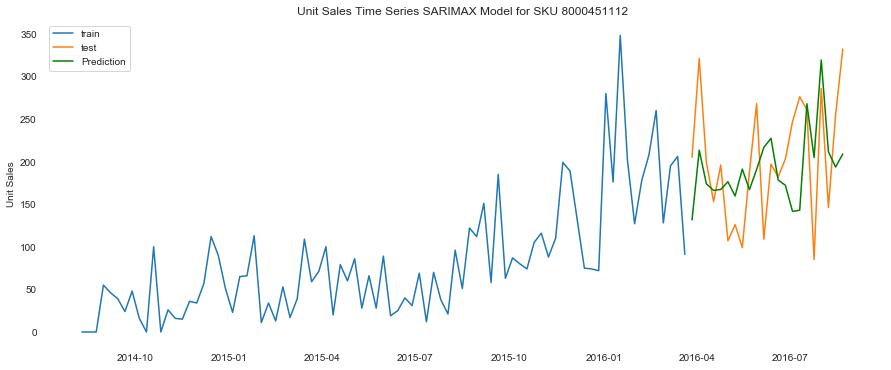

In [57]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(train_a, label="train")
ax.set_ylabel("Unit Sales")
ax.set_title("Unit Sales Time Series SARIMAX Model for SKU 8000451112")
ax.plot(test_a, label="test")
ax.plot(test_a_hat, color='green', label="Prediction")
ax.legend(loc="upper left")


sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
plt.show()

In [58]:
rms_a = sqrt(mean_squared_error(test_a, test_a_hat))
rms_a

73.98619446217886

#### Model Diagnostics

In [59]:
print(train_a_hat.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7397      0.094     -7.906      0.000      -0.923      -0.556
ar.S.L28      -0.4303      0.301     -1.431      0.153      -1.020       0.159
sigma2      3538.4994    677.270      5.225      0.000    2211.074    4865.925


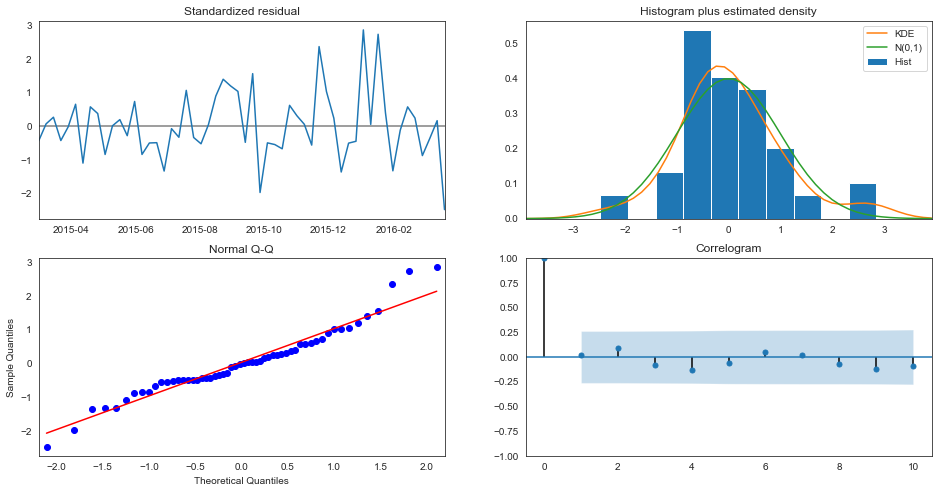

In [60]:
train_a_hat.plot_diagnostics(figsize=(16, 8))
plt.show()

Although not perfect, our model diagnostics suggest that our residuals are almost normally distributed.

#### ***ii. Modelling the rest***

First let's drop SKU 8000451112, since we've already predicted it, as well as SKU 50013000110, since it's the one with only one 5 weeks of sales in the entire dataset.

In [61]:
col_names_r = set(col_names) - {"8000451112", "50013000110"}
col_names_r = list(col_names_r)

Next, let's also merge SKU 50012011341 and 50012011340 into one column.

In [62]:
SKU_pivot["50012011341"] = SKU_pivot["50012011341"] + SKU_pivot["50012011340"]
SKU_pivot.drop(columns=["50012011340"], inplace=True)

In [63]:
col_names_r = set(col_names_r) - {"50012011340"}
col_names_r = list(col_names_r)

In [64]:
train_set = SKU_pivot[col_names_r].loc["2014-08-10":"2016-03-20"]
test_set = SKU_pivot[col_names_r].loc["2016-03-27":"2016-08-21"]

In [65]:
trains = ["b", "c", "d", "e", "f", "g"]
tests = ["b_hat", "c_hat", "d_hat", "e_hat", "f_hat", "g_hat"]

In [66]:
for i,j,k,l in zip(trains, col_names_r, tests, test_set):
    globals()[i] = SimpleExpSmoothing(train_set[j]).fit()
    globals()[k] = globals()[i].forecast(22)
    print("The rmse for SKU {} is {}".format(j, sqrt(mean_squared_error(test_set[l], globals()[k]))))

The rmse for SKU 7312455520 is 2.9440125521301734
The rmse for SKU 8000520021 is 10.42668827439148
The rmse for SKU 50012011341 is 3.7834326834466463
The rmse for SKU 7312455530 is 4.516461251134358
The rmse for SKU 50012011240 is 5.001714086733061
The rmse for SKU 50012011250 is 7.00690711400114


In [67]:
tests = [b_hat, c_hat, d_hat, e_hat, f_hat, g_hat]

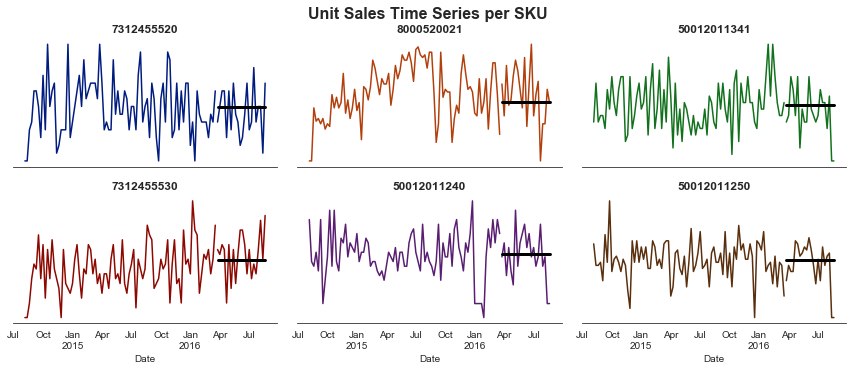

In [68]:
sns.set_style("white")
colors = sns.color_palette("dark", 9)

fig, axes = plt.subplots(nrows=2, ncols=3, sharex="row")

axes_list = [item for sublist in axes for item in sublist]

fig.suptitle("Unit Sales Time Series per SKU", fontsize=16, fontweight="bold", y=1.02)

for i, j, k, color in zip(train_set.columns, test_set.columns, tests, colors):
    ax = axes_list.pop(0)
    train_set.plot(y=i, label="train", ax=ax, legend=False, use_index=True, figsize=(12,5), color=color)
    test_set.plot(y=j, label="test", ax=ax, legend=False, use_index=True, figsize=(12,5), color=color)
    k.plot(ax=ax, label="Prediction", linewidth=3, color="black")
    ax.set_title(i, fontweight="bold")
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=True, labelleft=False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()

The RMSEs for these SKUs are all less than 11, which when compared to that of SKU 8000451112, are extremely low.

**NB**: Some of these SKUs **do** in fact exhibit *some* seasonality, but it is not clear. For this reason we'll maintain these SES models. Another reason why it isn't so detrimental to use models that don't account for seasonality is beacause the sales of these SKUs are relatively low. As such, the smoothed out values of the predictions when aggregated over a month will be more accurate. In a Supply Chain context, this is good because stocks/raw materials often have a minimum order level for them to make economic sense. Since these SKUs have low sales, their orders are most likely to be within this minimum order level. Therefore, our predictions will suffice.

#### **Final SKU Models**

We've now validated our models, so now create our final models using all of the data.

In [69]:
a = sm.tsa.statespace.SARIMAX(SKU_pivot["8000451112"], order=(0,1,1), enforce_stationarity=True, enforce_invertibility=False, seasonal_order=(1,1,0,28)).fit()
predict_a = a.predict(start="2016-08-28", end="2017-08-20", dynamic=True)

In [70]:
predicts = ["predict_b", "predict_c", "predict_d", "predict_e", "predict_f", "predict_g"]

In [71]:
for sku, pred in zip(col_names_r, predicts):
    i = SimpleExpSmoothing(SKU_pivot[sku]).fit()
    globals()[pred] = i.forecast(52)

In [72]:
predicts = [predict_a, predict_b, predict_c, predict_d, predict_e, predict_f, predict_g]

In [73]:
col_names_r.insert(0,"8000451112")

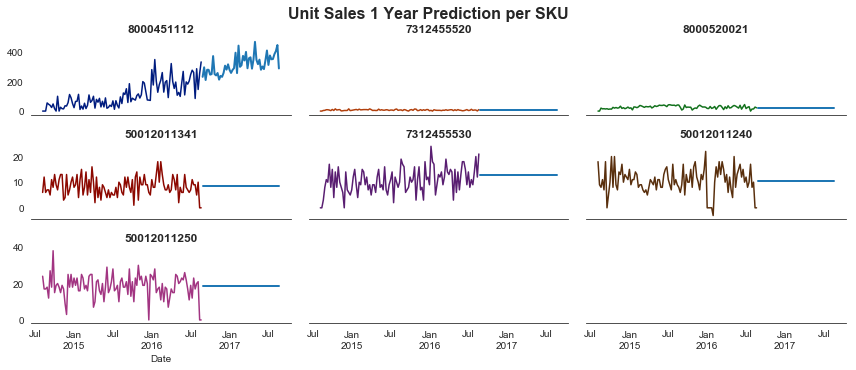

In [74]:
sns.set_style("white")
colors = sns.color_palette("dark", 7)

fig, axes = plt.subplots(nrows=3, ncols=3, sharex="row", sharey="row")

axes_list = [item for sublist in axes for item in sublist]

fig.suptitle("Unit Sales 1 Year Prediction per SKU", fontsize=16, fontweight="bold", y=1.02)

for sku, pred, color in zip(col_names_r, predicts, colors):
    ax = axes_list.pop(0)
    SKU_pivot.plot(y=sku, label="Unit Sales", ax=ax, legend=False, use_index=True, figsize=(12,5), color=color)
    pred.plot(ax=ax, label="Prediction", linewidth=2, legend=False)
    ax.set_title(sku, fontweight="bold")
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    #ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=True, labelleft=False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for ax in axes_list:
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    #ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=True, labelleft=False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()

#### **Demand Forecast Report**

Let's now create a report in the form of a table that summarises the forecast and what it means on a weekly perspective.

First, let's create a dataframe of our predictions

In [75]:
pred_dict = {}

for i,j in zip(col_names_r, predicts):
    pred_dict[i] = j

In [76]:
pred_df = pd.DataFrame(pred_dict)
pred_df.head()

,8000451112,7312455520,8000520021,50012011341,7312455530,50012011240,50012011250
2016-08-28,231.180989,6.794393,20.537529,8.373832,12.976664,10.53271,18.448598
2016-09-04,295.452200,6.794393,20.537529,8.373832,12.976664,10.53271,18.448598
2016-09-11,209.869391,6.794393,20.537529,8.373832,12.976664,10.53271,18.448598
2016-09-18,279.003515,6.794393,20.537529,8.373832,12.976664,10.53271,18.448598
2016-09-25,278.799365,6.794393,20.537529,8.373832,12.976664,10.53271,18.448598


Next, we need to make sure SKU_pivot has the same dimensions and columns as our predictions dataframe.

In [77]:
SKU_pivot = SKU_pivot[col_names_r]
SKU_pivot.head()

,8000451112,7312455520,8000520021,50012011341,7312455530,50012011240,50012011250
Date,,,,,,,
2014-08-10,0,0,0,6,0,18,24
2014-08-17,0,0,0,12,0,9,17
2014-08-24,0,4,20,6,3,8,17
2014-08-31,55,5,15,7,8,11,18
2014-09-07,46,9,16,7,11,7,12


SKU_pivot has data from Aug 2014 to Aug 2016. We made a prediction of 52 weeks, and that's  the length of pred_df. The main objective of our report is to obviously communicate the 1 year forecast we made, but we'd also like to compare this forecast with the previous year's performance. To do this, let's take the last 52 weeks of SKU_pivot, such that we've corresponding values in different years but the same period in those years for SKU_pivot and pred_df, respectively.

In [78]:
SKU_pivot = SKU_pivot.tail(52)
SKU_pivot.head()

,8000451112,7312455520,8000520021,50012011341,7312455530,50012011240,50012011250
Date,,,,,,,
2015-08-30,112,3,26,12,17,6,18
2015-09-06,151,10,7,8,16,9,21
2015-09-13,58,8,14,12,6,17,14
2015-09-20,185,3,41,8,7,5,28
2015-09-27,63,0,24,6,8,13,13


Now let's resample our dataframes by month. Recall that we used SES for predicting these sales (except for SKU 8000451112, of course). Therefore, we'd be decreasing in-month variation by doing this. Our forecast would become more accurate.

In [79]:
pred_df = pred_df.resample("M").sum()
SKU_pivot = SKU_pivot.resample("M").sum()

In [80]:
pred_df = pred_df.iloc[1:]
SKU_pivot = SKU_pivot.iloc[1:]

Let's now create a column in each dataframe that identifies which month of the financial year we're currently in.

In [81]:
month_locator = range(1,13)
SKU_pivot["Month"] = month_locator
pred_df["Month"] = month_locator

In [82]:
SKU_pivot.head()

,8000451112,7312455520,8000520021,50012011341,7312455530,50012011240,50012011250,Month
Date,,,,,,,,
2015-09-30,457,21,86,34,37,44,76,1
2015-10-31,346,37,86,38,49,43,73,2
2015-11-30,702,34,128,46,45,63,114,3
2015-12-31,353,34,114,29,44,61,69,4
2016-01-31,1133,22,106,58,73,-3,106,5


Let's also add a "Financial Year" column.

In [83]:
SKU_pivot["Fin Year"] = [2016] * 12
pred_df["Fin Year"] = [2017] * 12
SKU_pivot.head()

,8000451112,7312455520,8000520021,50012011341,7312455530,50012011240,50012011250,Month,Fin Year
Date,,,,,,,,,
2015-09-30,457,21,86,34,37,44,76,1,2016
2015-10-31,346,37,86,38,49,43,73,2,2016
2015-11-30,702,34,128,46,45,63,114,3,2016
2015-12-31,353,34,114,29,44,61,69,4,2016
2016-01-31,1133,22,106,58,73,-3,106,5,2016


Let's now merge our 2 dataframes so that it becomes one continuous dataframe.

In [84]:
merge_df = SKU_pivot.append(pred_df)

Now that we've our dataframe which has data identified by different hierachies of periods, let's create a pivot table for our report.

In [85]:
merge_df.head()

,8000451112,7312455520,8000520021,50012011341,7312455530,50012011240,50012011250,Month,Fin Year
2015-09-30,457.0,21.0,86.0,34.0,37.0,44.0,76.0,1,2016
2015-10-31,346.0,37.0,86.0,38.0,49.0,43.0,73.0,2,2016
2015-11-30,702.0,34.0,128.0,46.0,45.0,63.0,114.0,3,2016
2015-12-31,353.0,34.0,114.0,29.0,44.0,61.0,69.0,4,2016
2016-01-31,1133.0,22.0,106.0,58.0,73.0,-3.0,106.0,5,2016


In [86]:
report = merge_df.pivot_table(values=merge_df.columns, columns=["Fin Year"], index="Month", aggfunc=np.sum)
report

50012011240            50012011250            50012011341             \
Fin Year        2016       2017        2016       2017        2016       2017   
Month                                                                           
1               44.0  42.130841        76.0  73.794392        34.0  33.495327   
2               43.0  52.663551        73.0  92.242990        38.0  41.869159   
3               63.0  42.130841       114.0  73.794392        46.0  33.495327   
4               61.0  42.130841        69.0  73.794392        29.0  33.495327   
5               -3.0  52.663551       106.0  92.242990        58.0  41.869159   
6               56.0  42.130841        59.0  73.794392        50.0  33.495327   
7               56.0  42.130841        54.0  73.794392        29.0  33.495327   
8               38.0  52.663551        72.0  92.242990        38.0  41.869159   
9               60.0  42.130841       110.0  73.794392        35.0  33.495327   
10              54.0  42.130841        76.0  73.794392        34.0  33.495327   
11              55.0  52.663551        91.0  92.242990        41.0  41.869159   
12              10.0  31.598131        21.0  55.345794        10.0  25.121495   

         7312455520            7312455530            8000451112               \
Fin Year       2016       2017       2016       2017       2016         2017   
Month                                                                          
1              21.0  27.177570       37.0  51.906656      457.0  1063.124472   
2              37.0  33.971963       49.0  64.883320      346.0  1357.005719   
3              34.0  27.177570       45.0  51.906656      702.0   938.174860   
4              34.0  27.177570       44.0  51.906656      353.0  1159.903648   
5              22.0  33.971963       73.0  64.883320     1133.0  1497.783785   
6              18.0  27.177570       48.0  51.906656      774.0  1307.021098   
7              25.0  27.177570       54.0  51.906656      697.0  1403.181436   
8              28.0  33.971963       45.0  64.883320      869.0  1822.459680   
9              34.0  27.177570       55.0  51.906656      788.0  1288.861592   
10             21.0  27.177570       60.0  51.906656      691.0  1337.011528   
11             33.0  33.971963       56.0  64.883320     1155.0  1772.573637   
12             18.0  20.383178       53.0  38.929992      733.0  1139.518403   

         8000520021              
Fin Year       2016        2017  
Month                            
1              86.0   82.150115  
2              86.0  102.687644  
3             128.0   82.150115  
4             114.0   82.150115  
5             106.0  102.687644  
6             106.0   82.150115  
7             101.0   82.150115  
8              97.0  102.687644  
9             151.0   82.150115  
10            125.0   82.150115  
11             86.0  102.687644  
12             63.0   61.612586

In [87]:
for i in col_names_r:
    report[i,"Growth %"] = ((report[i,2017]-report[i,2016])/report[i,2016])*100
report = report.sort_index(axis=1)
report

50012011240                         50012011250             \
Fin Year        2016       2017     Growth %        2016       2017   
Month                                                                 
1               44.0  42.130841    -4.248088        76.0  73.794392   
2               43.0  52.663551    22.473375        73.0  92.242990   
3               63.0  42.130841   -33.125649       114.0  73.794392   
4               61.0  42.130841   -30.933047        69.0  73.794392   
5               -3.0  52.663551 -1855.451711       106.0  92.242990   
6               56.0  42.130841   -24.766355        59.0  73.794392   
7               56.0  42.130841   -24.766355        54.0  73.794392   
8               38.0  52.663551    38.588293        72.0  92.242990   
9               60.0  42.130841   -29.781932       110.0  73.794392   
10              54.0  42.130841   -21.979924        76.0  73.794392   
11              55.0  52.663551    -4.248088        91.0  92.242990   
12              10.0  31.598131   215.981308        21.0  55.345794   

                     50012011341                        7312455520    ...      \
Fin Year    Growth %        2016       2017    Growth %       2016    ...       
Month                                                                 ...       
1          -2.902116        34.0  33.495327   -1.484332       21.0    ...       
2          26.360260        38.0  41.869159   10.181997       37.0    ...       
3         -35.268077        46.0  33.495327  -27.184071       34.0    ...       
4           6.948394        29.0  33.495327   15.501128       34.0    ...       
5         -12.978311        58.0  41.869159  -27.811795       22.0    ...       
6          25.075241        50.0  33.495327  -33.009346       18.0    ...       
7          36.656282        29.0  33.495327   15.501128       25.0    ...       
8          28.115264        38.0  41.869159   10.181997       28.0    ...       
9         -32.914189        35.0  33.495327   -4.299065       34.0    ...       
10         -2.902116        34.0  33.495327   -1.484332       21.0    ...       
11          1.365923        41.0  41.869159    2.119900       33.0    ...       
12        163.551400        10.0  25.121495  151.214954       18.0    ...       

                    7312455530                       8000451112               \
Fin Year   Growth %       2016       2017   Growth %       2016         2017   
Month                                                                          
1         29.417000       37.0  51.906656  40.288261      457.0  1063.124472   
2         -8.183885       49.0  64.883320  32.414940      346.0  1357.005719   
3        -20.065970       45.0  51.906656  15.348125      702.0   938.174860   
4        -20.065970       44.0  51.906656  17.969674      353.0  1159.903648   
5         54.418012       73.0  64.883320 -11.118739     1133.0  1497.783785   
6         50.986501       48.0  51.906656   8.138867      774.0  1307.021098   
7          8.710280       54.0  51.906656  -3.876562      697.0  1403.181436   
8         21.328438       45.0  64.883320  44.185157      869.0  1822.459680   
9        -20.065970       55.0  51.906656  -5.624261      788.0  1288.861592   
10        29.417000       60.0  51.906656 -13.488906      691.0  1337.011528   
11         2.945341       56.0  64.883320  15.863072     1155.0  1772.573637   
12        13.239875       53.0  38.929992 -26.547184      733.0  1139.518403   

                     8000520021                         
Fin Year    Growth %       2016        2017   Growth %  
Month                                                   
1         132.631175       86.0   82.150115  -4.476610  
2         292.198185       86.0  102.687644  19.404237  
3          33.643142      128.0   82.150115 -35.820223  
4         228.584603      114.0   82.150115 -27.938496  
5          32.196274      106.0  102.687644  -3.124864  
6          68.865775      106.0   82.150115 -22.499891  
7         101

The Growth % for SKU 50012011240, month 5 is negative. However, this isn't because the SKU didn't grow, it's because the 2016 value is negative (returns) and that affected our formula. Let's correct it.

In [88]:
idx = pd.IndexSlice
report.loc[5,idx["50012011240","Growth %"]] = report.loc[5,idx["50012011240","Growth %"]] * (-1)
report

50012011240                         50012011250             \
Fin Year        2016       2017     Growth %        2016       2017   
Month                                                                 
1               44.0  42.130841    -4.248088        76.0  73.794392   
2               43.0  52.663551    22.473375        73.0  92.242990   
3               63.0  42.130841   -33.125649       114.0  73.794392   
4               61.0  42.130841   -30.933047        69.0  73.794392   
5               -3.0  52.663551  1855.451711       106.0  92.242990   
6               56.0  42.130841   -24.766355        59.0  73.794392   
7               56.0  42.130841   -24.766355        54.0  73.794392   
8               38.0  52.663551    38.588293        72.0  92.242990   
9               60.0  42.130841   -29.781932       110.0  73.794392   
10              54.0  42.130841   -21.979924        76.0  73.794392   
11              55.0  52.663551    -4.248088        91.0  92.242990   
12              10.0  31.598131   215.981308        21.0  55.345794   

                     50012011341                        7312455520    ...      \
Fin Year    Growth %        2016       2017    Growth %       2016    ...       
Month                                                                 ...       
1          -2.902116        34.0  33.495327   -1.484332       21.0    ...       
2          26.360260        38.0  41.869159   10.181997       37.0    ...       
3         -35.268077        46.0  33.495327  -27.184071       34.0    ...       
4           6.948394        29.0  33.495327   15.501128       34.0    ...       
5         -12.978311        58.0  41.869159  -27.811795       22.0    ...       
6          25.075241        50.0  33.495327  -33.009346       18.0    ...       
7          36.656282        29.0  33.495327   15.501128       25.0    ...       
8          28.115264        38.0  41.869159   10.181997       28.0    ...       
9         -32.914189        35.0  33.495327   -4.299065       34.0    ...       
10         -2.902116        34.0  33.495327   -1.484332       21.0    ...       
11          1.365923        41.0  41.869159    2.119900       33.0    ...       
12        163.551400        10.0  25.121495  151.214954       18.0    ...       

                    7312455530                       8000451112               \
Fin Year   Growth %       2016       2017   Growth %       2016         2017   
Month                                                                          
1         29.417000       37.0  51.906656  40.288261      457.0  1063.124472   
2         -8.183885       49.0  64.883320  32.414940      346.0  1357.005719   
3        -20.065970       45.0  51.906656  15.348125      702.0   938.174860   
4        -20.065970       44.0  51.906656  17.969674      353.0  1159.903648   
5         54.418012       73.0  64.883320 -11.118739     1133.0  1497.783785   
6         50.986501       48.0  51.906656   8.138867      774.0  1307.021098   
7          8.710280       54.0  51.906656  -3.876562      697.0  1403.181436   
8         21.328438       45.0  64.883320  44.185157      869.0  1822.459680   
9        -20.065970       55.0  51.906656  -5.624261      788.0  1288.861592   
10        29.417000       60.0  51.906656 -13.488906      691.0  1337.011528   
11         2.945341       56.0  64.883320  15.863072     1155.0  1772.573637   
12        13.239875       53.0  38.929992 -26.547184      733.0  1139.518403   

                     8000520021                         
Fin Year    Growth %       2016        2017   Growth %  
Month                                                   
1         132.631175       86.0   82.150115  -4.476610  
2         292.198185       86.0  102.687644  19.404237  
3          33.643142      128.0   82.150115 -35.820223  
4         228.584603      114.0   82.150115 -27.938496  
5          32.196274      106.0  102.687644  -3.124864  
6          68.865775      106.0   82.150115 -22.499891  
7         101

In [89]:
report.round()

50012011240                50012011250                50012011341  \
Fin Year        2016  2017 Growth %        2016  2017 Growth %        2016   
Month                                                                        
1               44.0  42.0     -4.0        76.0  74.0     -3.0        34.0   
2               43.0  53.0     22.0        73.0  92.0     26.0        38.0   
3               63.0  42.0    -33.0       114.0  74.0    -35.0        46.0   
4               61.0  42.0    -31.0        69.0  74.0      7.0        29.0   
5               -3.0  53.0   1855.0       106.0  92.0    -13.0        58.0   
6               56.0  42.0    -25.0        59.0  74.0     25.0        50.0   
7               56.0  42.0    -25.0        54.0  74.0     37.0        29.0   
8               38.0  53.0     39.0        72.0  92.0     28.0        38.0   
9               60.0  42.0    -30.0       110.0  74.0    -33.0        35.0   
10              54.0  42.0    -22.0        76.0  74.0     -3.0        34.0   
11              55.0  53.0     -4.0        91.0  92.0      1.0        41.0   
12              10.0  32.0    216.0        21.0  55.0    164.0        10.0   

                        7312455520   ...             7312455530        \
Fin Year  2017 Growth %       2016   ...    Growth %       2016  2017   
Month                                ...                                
1         33.0     -1.0       21.0   ...        29.0       37.0  52.0   
2         42.0     10.0       37.0   ...        -8.0       49.0  65.0   
3         33.0    -27.0       34.0   ...       -20.0       45.0  52.0   
4         33.0     16.0       34.0   ...       -20.0       44.0  52.0   
5         42.0    -28.0       22.0   ...        54.0       73.0  65.0   
6         33.0    -33.0       18.0   ...        51.0       48.0  52.0   
7         33.0     16.0       25.0   ...         9.0       54.0  52.0   
8         42.0     10.0       28.0   ...        21.0       45.0  65.0   
9         33.0     -4.0       34.0   ...       -20.0       55.0  52.0   
10        33.0     -1.0       21.0   ...        29.0       60.0  52.0   
11        42.0      2.0       33.0   ...         3.0       56.0  65.0   
12        25.0    151.0       18.0   ...        13.0       53.0  39.0   

                  8000451112                  8000520021                  
Fin Year Growth %       2016    2017 Growth %       2016   2017 Growth %  
Month                                                                     
1            40.0      457.0  1063.0    133.0       86.0   82.0     -4.0  
2            32.0      346.0  1357.0    292.0       86.0  103.0     19.0  
3            15.0      702.0   938.0     34.0      128.0   82.0    -36.0  
4            18.0      353.0  1160.0    229.0      114.0   82.0    -28.0  
5           -11.0     1133.0  1498.0     32.0      106.0  103.0     -3.0  
6             8.0      774.0  1307.0     69.0      106.0   82.0    -22.0  
7            -4.0      697.0  1403.0    101.0      101.0   82.0    -19.0  
8            44.0      869.0  1822.0    110.0       97.0  103.0      6.0  
9            -6.0      788.0  1289.0     64.0      151.0   82.0    -46.0  
10          -13.0      691.0  1337.0     93.0      125.0   82.0    -34.0  
11           16.0     1155.0  1773.0     53.0       86.0  103.0     19.0  
12          -27.0      733.0  1140.0     55.0       63.0   62.0     -2.0  

[12 rows x 21 columns]

Let's export our report to a csv format so that it can be shared to relevant stakeholders.

In [90]:
# Use your own paths.
report.to_csv("/Users/mac/Desktop/Data Science/Projects/TinyCo Project/Unit Sales Forecast Report (by SKU.csv")

It seems that our report is now complete. It shows the sales (by SKU) of the last year we've on record (2016), the sales of the 1 year forecast our model predicted (2017) and the subsequent percentage growth in sales we're expecting. All these are divided into the 12 months of our financial year.

### **Summary and Conclusion**

The main objective of our project was to:
 - Develop a Demand Forecast to assist the business with Supply Planning.

We were able to achieve this through:
 - model building,
 - model validation &
 - model selection.

We created a model that forecasted the Overall Unit Sales 1 year into the future, and designed a report that described how we would expect sales to perform the following year compared to the most recent/current year.

Although overall sales are useful to plan for inventory levels and possibly storage logistics, they do not provide a clear picture of the granular contribution each SKU makes to the grand total. Because of this, models were built for each SKU to create a valid forecast that was based on each SKU's performace and pattern.

Apart from the best selling SKU 8000451112, all the time series for the other SKUs resembled patterns akin to stationarity. For this reason, Simple Exponential Smoothing was chosen to forecast them, a technique that produces a smoothed out average which becomes more accurate the more you aggregate your data. A report similar to the one produced for the overall time series was produced, showing the same information per SKU.

Each step was accompanied by the appropriate visualisations.

In conclusion, we were able to produce a demand forecast(s) that is robust given the limited range of data we had to deal with. The main recommendation I would make to the Supply CHain Department when using this model would be to use it every quarter, then feed it the new data that'd have been collected in that period. The model should then be evaluated and adjusted as appropriate.

This is the end of my project. Recall that we only dealt with Store_312 throughout. Depending on your reasons for going through the project, please feel free to attempt to answer the same questions I posed in this undertaking with any of the other stores the dataset provides.

I am open to any suggestions, questions, criticisms or comments you might have. Please just remember to be polite.

**End of Part 3**

**End of Project**

<br>
<br>
<br>
<br>
***
<footer>_Author: Simbarashe Chikaura -- Data Analyst_</footer>
***